In [101]:
import networkx as nx
import matplotlib.pyplot as plt
from csv import DictReader
from itertools import groupby
import gtfs_kit as gk
import numpy as np
import pandas as pd
import os
import h3
from tqdm import tqdm
import contextily as cx
import numpy as np

In [116]:
def get_stop_id(stop_id):
    """ translate stop_id to parent_stop_id 
        if available
    """
    if 'parent_station' not in STOPS[stop_id].keys():
        return stop_id
    elif STOPS[stop_id]['parent_station'] == '' or np.isnan(STOPS[stop_id]['parent_station']):
        return stop_id
    else:
        return STOPS[stop_id]['parent_station']


def add_stop_to_graph(G, stop_id):
    """ add stop as new node to graph
    """
    #lookup details of the stop (parent stop if available)
    node = STOPS[get_stop_id(stop_id)]

    if node['stop_id'] not in G.nodes:
        G.add_node(node['stop_id'], 
                   stop_name = node['stop_name'], 
                   stop_lon = node['stop_lon'], 
                   stop_lat = node['stop_lat'])
    return G

def add_edge_to_graph(G, from_id, to_id, route_short_name):
    """ add edge to graph 
        adding the route short name as a key
        if the edge and key exist, increment the count
    """
    edge = G.get_edge_data(get_stop_id(from_id), get_stop_id(to_id),route_short_name, default = 0)
    if edge == 0:
        G.add_edge(get_stop_id(from_id), get_stop_id(to_id), 
                   key=route_short_name,
                   count=1)
    else:
        G.add_edge(get_stop_id(from_id), get_stop_id(to_id), 
                   key=route_short_name,
                   count=edge['count']+1)

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

In [405]:
# put all gtfs zips in one directory

# assign directory
directory = '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/'
files = gk.list_feed(directory)
files=files[files['file_name'].str.contains('.zip')]['file_name']
files = list(directory+files)

In [406]:
files

['/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/mta_brooklyn_gtfs.zip',
 '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/mta_bronx_gtfs.zip',
 '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/mta_manhattan_gtfs.zip',
 '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/subway_gtfs.zip',
 '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/mta_queens_gtfs.zip',
 '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/nyc_ferry.zip',
 '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/long_island_railroad.zip',
 '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/mta_staten_island_gtfs.zip',
 '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/metro_north_gtfs.zip']

In [418]:
def generate_all_dfs(files):
    
    feed = (gk.read_feed(files[0], dist_units='km'))
    STOPS, ROUTES, TRIPS, stop_times = generate_sub_gtfs_dfs(feed)
    
    for i in range(1,len(files)):
        feed = (gk.read_feed(files[i], dist_units='km'))
        temp_STOPS, temp_ROUTES, temp_TRIPS, temp_stop_times = generate_sub_gtfs_dfs(feed)
        
        stop_times = pd.concat([stop_times, temp_stop_times])
        
        STOPS.update(temp_STOPS)
        ROUTES.update(temp_ROUTES)
        TRIPS.update(temp_TRIPS)
        
    
    return STOPS, ROUTES, TRIPS, stop_times, feed

In [419]:
def generate_sub_gtfs_dfs(feed):
    STOPS = feed.get_stops().set_index('stop_id').to_dict('index')

    for key in STOPS.keys():
        STOPS[key]['stop_id'] = key
        
    ROUTES = feed.get_routes().set_index('route_id').to_dict('index')

    for key in ROUTES.keys():
        ROUTES[key]['route_id'] = key

    TRIPS = feed.get_trips().set_index('trip_id').to_dict('index')

    for key in TRIPS.keys():
        TRIPS[key]['route_short_name'] = ROUTES[TRIPS[key]['route_id']]['route_short_name']
        TRIPS[key]['trip_id'] = key
        
    stop_times = feed.get_stop_times()
    
    return STOPS, ROUTES, TRIPS, stop_times

In [420]:
STOPS, ROUTES, TRIPS, stop_times, feed = generate_all_dfs(files)

In [421]:
# sort just to be sure
# didn't actually check that there are no repeated trip_ids across public transport types
sorted_stops = stop_times.sort_values(['trip_id', 'stop_sequence'], ascending=[True, True])

In [422]:
# rewrote using numpy array to increase speed significantly
trip_ids = sorted_stops['trip_id'].to_numpy()
stops_ids = sorted_stops['stop_id'].to_numpy()

In [423]:
stops = set()
edges = dict()

# build network
next_trip = trip_ids[1]
for i in tqdm(range(len(stops_ids)-1)):
    if trip_ids[i] in TRIPS:
        trip = TRIPS[trip_ids[i]]
        # if we are still on the same route, create edges
        if trip_ids[i]==next_trip:
            stop = stops_ids[i]
            stops.add(stop)
            next_stop = stops_ids[i+1]
            edge = (stop, next_stop)
            edges[edge] = trip['route_short_name']
        # we start a new route
        else:
            stop = stops_ids[i]
            stops.add(stop)
        
        if i < len(stops_ids)-2:
            next_trip=trip_ids[i+2]
        else:
            next_trip = -1
        
# add the final stop to the list
stops.add(next_stop)

100%|█████████████████████████████| 3066740/3066740 [00:06<00:00, 455355.49it/s]


In [424]:
G = nx.MultiGraph()

In [425]:
print ('stops', len(stops))
print ('edges', len(edges))

for stop_id in STOPS:
    if stop_id in stops:
        add_stop_to_graph(G, stop_id)
        
print('Nodes:', G.number_of_nodes() )
        
for (start_stop_id, end_stop_id), route_short_name in edges.items():
    if start_stop_id==end_stop_id:
        print(start_stop_id, end_stop_id, route_short_name)
    add_edge_to_graph(G, 
                      from_id = start_stop_id, 
                      to_id = end_stop_id, 
                      route_short_name=route_short_name)
print('Edges:', G.number_of_edges() )



deg = nx.degree(G)
labels = {stop_id: G.nodes[stop_id]['stop_name'] if deg[stop_id] >= 0 else ''
          for stop_id in G.nodes}

pos = {stop_id: (G.nodes[stop_id]['stop_lon'], G.nodes[stop_id]['stop_lat'])
       for stop_id in G.nodes}

stops 6851
edges 7453
Nodes: 6851
Edges: 7453


# Metric Scaling

min/max scale each disconnected component, then scale by the number of nodes in each component by multiplying by num nodes in component/total num nodes

In [426]:
G_simple = nx.Graph(G)

In [427]:
btw = nx.betweenness_centrality(G_simple)

In [428]:
# create scaled betweenness dictionary

l=np.zeros(len(btw))
keys=list(btw.keys())

for i in range(len(btw)):
    l[i]=btw[keys[i]]
    
# linear scale factor for betweenness
scale = (9/np.max(l))

for key in btw.keys():
    btw[key] = (btw[key]*scale)+1

In [429]:
nx.set_node_attributes(G_simple, btw, "betweenness")

In [430]:
#nx.write_graphml(G,'g.xml')
#nx.write_graphml(G_simple,'g_simple_fast.xml')

In [431]:
# wrangle betweenness to df with coordinates
df_btw = pd.DataFrame.from_dict(btw, orient='index')
df_btw.columns=['betweenness']

betweenness_geo = df_btw.join(pd.DataFrame.from_dict(pos, orient='index'))
betweenness_geo.columns = ['betweenness','lon','lat']

In [432]:
# using number of departures as a frequency proxy 
betweenness_geo = betweenness_geo.join(
    stop_times['stop_id'].value_counts()).rename(
    columns={'stop_id':'num_departures'})

# arbitrarily set the scale to be 2.5,  This says frequency is about 25% as important as betweenness
scale = (2.5/betweenness_geo['num_departures'].max())

betweenness_geo['num_departures_scaled'] = (betweenness_geo['num_departures']*scale)+1

In [433]:
# FIND LIT FOR THIS, ARBITRARY FUNCTION
# create accessibility score
betweenness_geo['accessibility_score'] = \
    betweenness_geo['num_departures_scaled']+betweenness_geo['betweenness']

<AxesSubplot:xlabel='betweenness', ylabel='num_departures_scaled'>

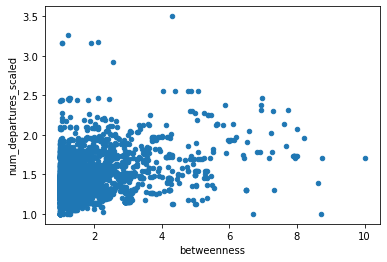

In [434]:
betweenness_geo.plot.scatter(x='betweenness',y='num_departures_scaled')

<AxesSubplot:>

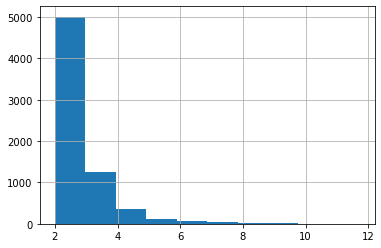

In [435]:
betweenness_geo['accessibility_score'].hist()

In [436]:
# we need to get route type for each stop to do the k-ring calc
temp_r = pd.DataFrame.from_dict(ROUTES, orient='index')[['route_type','route_id']]
temp_r = pd.DataFrame.from_dict(TRIPS, orient='index')[['route_id','trip_id']].merge(temp_r, on='route_id')
stop_times = stop_times.merge(temp_r, on='trip_id')

In [437]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,route_id,route_type
0,EN_B2-Weekday-028500_SBS82_901,04:45:00,04:45:00,304083,1,0,0,B82+,3
1,EN_B2-Weekday-028500_SBS82_901,04:47:37,04:47:37,304085,2,0,0,B82+,3
2,EN_B2-Weekday-028500_SBS82_901,04:49:08,04:49:08,308865,3,0,0,B82+,3
3,EN_B2-Weekday-028500_SBS82_901,04:51:39,04:51:39,306950,4,0,0,B82+,3
4,EN_B2-Weekday-028500_SBS82_901,04:53:54,04:53:54,304092,5,0,0,B82+,3


In [438]:
betweenness_geo = betweenness_geo.join(stop_times[['stop_id','route_type']].set_index('stop_id'))

# STOPS Metrics as points BEFORE hex aggregation

In [439]:
betweenness_geo.head()

,betweenness,lon,lat,num_departures,num_departures_scaled,accessibility_score,route_type
100014,1.142708,-73.888156,40.872562,299,1.252448,2.395157,3
100014,1.142708,-73.888156,40.872562,299,1.252448,2.395157,3
100014,1.142708,-73.888156,40.872562,299,1.252448,2.395157,3
100014,1.142708,-73.888156,40.872562,299,1.252448,2.395157,3
100014,1.142708,-73.888156,40.872562,299,1.252448,2.395157,3


In [440]:
len(betweenness_geo)

3066741

# Hex aggregation

In [441]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)
metric_col = 'accessibility_score'

# find hexs containing the points
betweenness_geo[hex_col] = betweenness_geo.apply(lambda x: h3.geo_to_h3(x.lat,x.lon,APERTURE_SIZE),1)

# sum accessibility grouped by route type and hex
hex_df = pd.DataFrame(
    betweenness_geo.groupby([hex_col,'route_type'])[metric_col].agg('sum')).reset_index()

In [442]:
hex_df.head()

,hex9,route_type,accessibility_score
0,892a1000063ffff,3,1953.600120
1,892a1000067ffff,3,968.130887
2,892a100007bffff,3,1481.070548
3,892a1000243ffff,3,4999.564505
4,892a100024bffff,3,1472.843506


In [443]:
mapping={ # h3_resolution: {transport type : num_k_rings}
    8:{1:2, 2:2, 3:1, 4:2},
    9:{1:5, 2:5, 3:3, 4:5},
    10:{1:12, 2:12, 3:7, 4:12}
}

# K_RING by Route Type

In [444]:
k_ring_all_types = pd.DataFrame(columns=[hex_col, 'accessibility_score', 'lat','lon'])                            
grouped_hex = hex_df.groupby('route_type')
for key, value in grouped_hex: 
    k_ring_all_types = pd.concat([k_ring_all_types,
        kring_smoothing(value, hex_col, metric_col=metric_col, k=mapping[APERTURE_SIZE][key])])

In [445]:
len(k_ring_all_types)

4572

In [446]:
k_ring_all_types

,hex9,accessibility_score,lat,lon
0,892a1000003ffff,118.994637,40.858416,-73.781928
1,892a1000007ffff,145.003944,40.855826,-73.779693
2,892a100000bffff,118.994637,40.858308,-73.786214
3,892a100000fffff,145.003944,40.855718,-73.783978
4,892a100001bffff,92.828937,40.861007,-73.784163
...,...,...,...,...
4567,892a10776cbffff,532.723753,40.674963,-74.021257
4568,892a10776cfffff,616.443228,40.672383,-74.019017
4569,892a10776d3ffff,760.202039,40.677777,-74.014958
4570,892a10776d7ffff,1062.677289,40.675197,-74.012718


In [447]:
# sum all layers of smoothed route types
k_ring_all_types = k_ring_all_types.groupby([hex_col])['accessibility_score'].agg('sum').reset_index()
#find center of hex for visualization
k_ring_all_types['lat'] = k_ring_all_types[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
k_ring_all_types['lon'] = k_ring_all_types[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

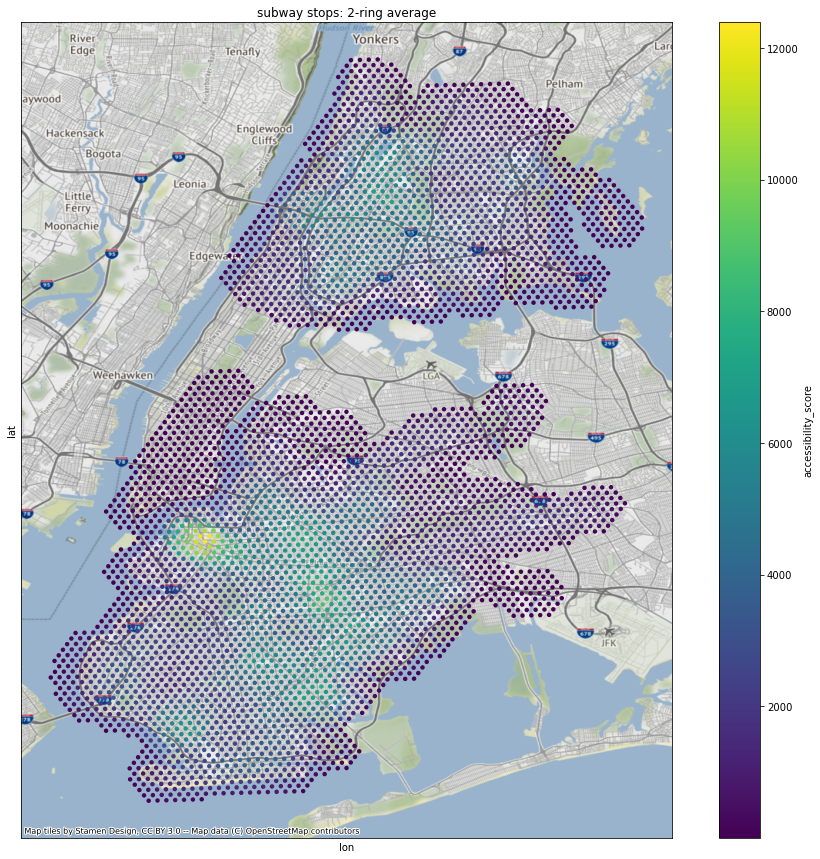

In [448]:
fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
k_ring_all_types.plot.scatter(ax=ax, x='lon', y='lat', c=metric_col,
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])
plt.title('subway stops: 2-ring average');

cx.add_basemap(ax=ax, crs="EPSG:4326")

In [244]:
hex_df.head()

,hex10,accessibility_score,lat,lon
0,8a2a1001958ffff,2.476744,40.805588,-73.837624
1,8a2a1001b8c7fff,4.057638,40.803794,-73.848577
2,8a2a10089b6ffff,7.231824,40.777150,-73.942437
3,8a2a100d008ffff,2.709302,40.741511,-73.961555
4,8a2a100d048ffff,3.753503,40.743864,-73.972345


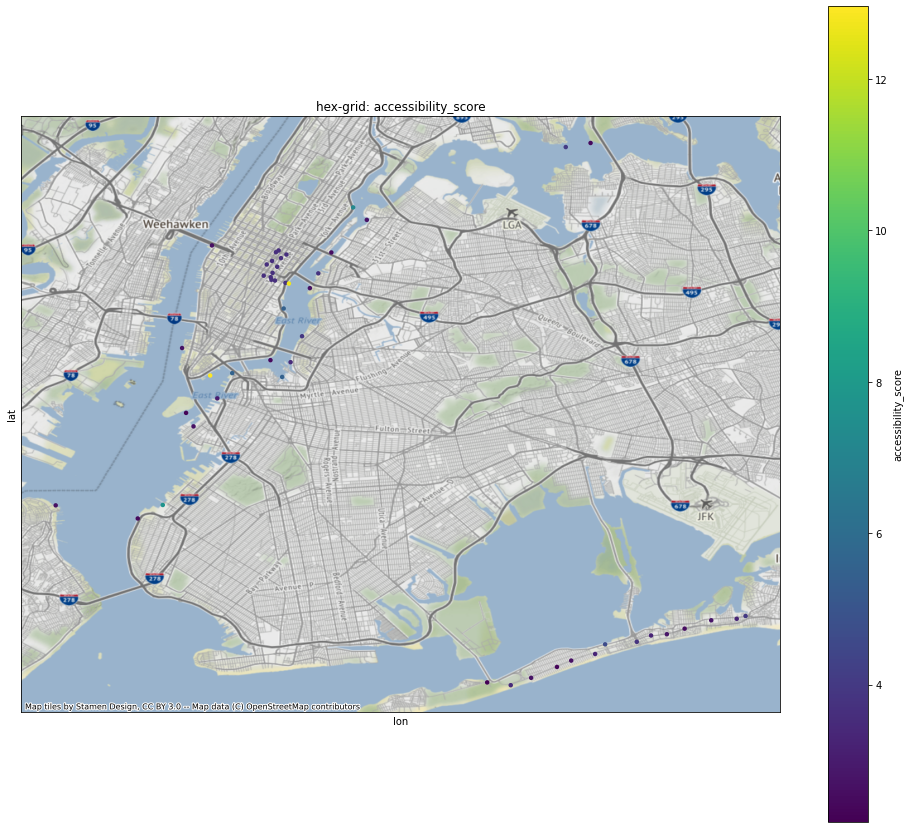

In [245]:
fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
hex_df.plot.scatter(ax=ax, x='lon', y='lat', c=metric_col,
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])

plt.title('hex-grid: '+metric_col);

cx.add_basemap(ax=ax, crs="EPSG:4326")

# K ring smoothing

# Notes

# nyc gtfs types
- bus is type 3
- subway is type 1
- suburban railway is type 2
- ferry is type 4

People are willing to walk:

    -805m to a train
    -461m to a bus
    
https://www.jstor.org/stable/26202654?seq=1

for buses:
- h8= 1 k-ring
- h9 = 3 k-rings
- h10 = 7 k-rings

for trains:
- h8= 2 k-rings
- h9 = 5 k-rings
- h10 = 12 k-rings

Hexagon edge distance by h3 resolution:

- 8:   0.461354684 km

- 9:	  0.174375668 km

- 10:  0.065907807 km

# OLD

In [117]:
DATA_ROOT='/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/nyc_ferry.zip'
#DATA_ROOT='/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/subway_gtfs/'
TRIPS_FILE = f'{DATA_ROOT}trips.txt'
ROUTES_FILE = f'{DATA_ROOT}routes.txt'
STOPS_FILE = f'{DATA_ROOT}stops.txt'

INCLUDE_AGENCIES=['MTA NYCT']
IGNORE_ROUTE=[]

In [164]:
h8= 0.461354684
h9= 0.174375668
h10= 0.065907807

In [165]:
# which k-ring is closest to the calculated value people will walk to this type of pt? BUSES
print(h9*2-0.461)
print(h9*3-0.461)
print()
print(h10*6-0.461)
print(h10*7-0.461)

-0.112248664
0.062127003999999986

-0.065553158
0.00035464899999998467


In [166]:
# which k-ring is closest to the calculated value people will walk to this type of pt? TRAINS
print(h8*2-0.805)
print(h8*3-0.805)
print()
print(h9*4-0.805)
print(h9*5-0.805)
print()
print(h10*12-0.805)
print(h10*13-0.805)

0.11770936799999998
0.579064052

-0.107497328
0.06687834000000004

-0.014106316000000008
0.05180149099999998


In [120]:
feed = (gk.read_feed(DATA_ROOT, dist_units='km'))

In [121]:
STOPS = feed.get_stops().set_index('stop_id').to_dict('index')

for key in STOPS.keys():
    STOPS[key]['stop_id'] = key

In [122]:
ROUTES = feed.get_routes().set_index('route_id').to_dict('index')

for key in ROUTES.keys():
    ROUTES[key]['route_id'] = key

In [123]:
TRIPS = feed.get_trips().set_index('trip_id').to_dict('index')

for key in TRIPS.keys():
    TRIPS[key]['route_short_name'] = ROUTES[TRIPS[key]['route_id']]['route_short_name']
    TRIPS[key]['trip_id'] = key

In [345]:
stop_times = feed.get_stop_times()

In [243]:
# OLD


APERTURE_SIZE = 10
hex_col = 'hex'+str(APERTURE_SIZE)
metric_col = 'accessibility_score'

# find hexs containing the points
betweenness_geo[hex_col] = betweenness_geo.apply(lambda x: h3.geo_to_h3(x.lat,x.lon,APERTURE_SIZE),1)

# we take the average accessibility score when aggregating the stops in each hex bin
# if you already live near a super central stop, then it doesnt matter how many
# if we sum, we are saying that there is only gain to live next to multiple stops
# assuming that most public transportation is designed to bring people to different places
# living next to two stops probably gives you asccess to two different places
# a better analysis might only sum when two stops are no on the same route.
hex_df = pd.DataFrame(
    betweenness_geo.groupby([hex_col])[metric_col].agg('mean')).reset_index()

#find center of hex for visualization
hex_df['lat'] = hex_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
hex_df['lon'] = hex_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [247]:
# nyc gtfs types
#subway is type 1
#suburban railway is type 2
#bus is type 3
#ferry is type 4
    
mapping={ # transport type: {h3_resolution : num_k_rings}
    1:{8:2, 9:5, 10:12},
    2:{8:2, 9:5, 10:12}, # unfinished / unknown
    3:{8:1, 9:3, 10:7},
    4:{8:2, 9:5, 10:12}  # unfinished / unknown
}

sum sanity check: 1.0000000000000002


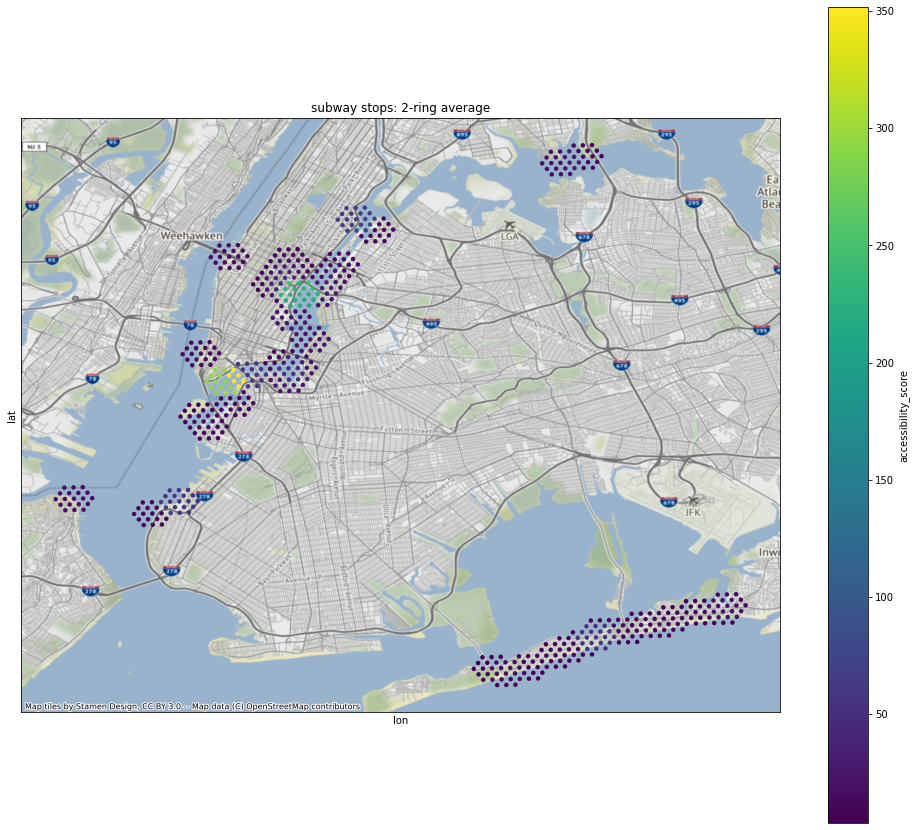

In [373]:
#kring_smoothing
# if you smooth in sections, you'll have to do a final smoothing at the end
# CURRENTLY IT SMOOTHS OUT IN A UNIFORM WAY, SHOULD CONVERT TO GAUSSIAN AS YOU GO OUT IN RINGS FROM CENTER
k = 2
stops_kring= kring_smoothing(hex_df, hex_col, metric_col=metric_col, k=k)
print('sum sanity check:', stops_kring[metric_col].sum() / hex_df[metric_col].sum())

fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
stops_kring.plot.scatter(ax=ax, x='lon', y='lat', c=metric_col,
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])
plt.title('subway stops: 2-ring average');

cx.add_basemap(ax=ax, crs="EPSG:4326")

In [172]:
stops_kring

,hex10,betweenness,lat,lon
0,8a2a10019407fff,0.052632,40.804125,-73.835735
1,8a2a10019417fff,0.052632,40.804463,-73.837277
2,8a2a1001941ffff,0.052632,40.803339,-73.836931
3,8a2a10019427fff,0.052632,40.804912,-73.834539
4,8a2a10019437fff,0.052632,40.805250,-73.836081
...,...,...,...,...
810,8a2a107726f7fff,0.052632,40.641264,-74.039436
811,8a2a10772a97fff,0.313194,40.646221,-74.023771
812,8a2a10772a9ffff,0.313194,40.645099,-74.023421
813,8a2a10776d27fff,0.063580,40.678564,-74.013768
